# Sentiment Analysis of Twitter Data - #Zeroplastic

In [1]:
#importing libraries
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import inflect
import re
import pandas as pd
import emoji
import json 
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Amma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Input data files are available in the "dataset/" directory.
# Read the input raw data and parse only the necessary columns from the json file.
from datetime import datetime
def populate_tweet_df(tweets):
    """
    This function takes tweets list as argument and returns a dataframe of the tweets.
    """
    df = pd.DataFrame()
    df['date'] = [datetime.strptime(tweet['created_at'],'%a %b %d %H:%M:%S %z %Y') for tweet in tweets if (tweet['lang'] == 'en')]
    df['text'] = [tweet['text'] for tweet in tweets if (tweet['lang'] == 'en')]
    # df['text'] = list(map(lambda tweet:tweet['text'], filter(lambda tweet: tweet['lang']=='en', tweets)))
    return df

if __name__ == '__main__':
    tweet_file1 = ("tweets_zeroplastic.txt")
    tweets = []
    with open(tweet_file1, 'r') as file:
        for line in file.readlines():
            tweets.append(json.loads(line))
    
    tweets_df = populate_tweet_df(tweets)
    print("Executed Successfully")

Executed Successfully


In [3]:
tweets_df.head()

,date,text
0,2020-03-09 14:21:05+00:00,💬“There is no such thing as ‘away’. When we th...
1,2020-03-09 13:42:32+00:00,Ditch the plastic. Custom tote bags with desig...
2,2020-03-09 13:15:54+00:00,Itsu's solution to plastic.....\n\nIt feels be...
3,2020-03-09 13:14:12+00:00,RT @EarthbasicsU: All our products are 🍃🍂 #bio...
4,2020-03-09 11:16:25+00:00,RT @EarthbasicsU: All our products are 🍃🍂 #bio...


In [4]:
#Creating Dictionary for Contractions
contractions_dict = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

## Data Cleaning

In [5]:
# Instantiate the WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
     
#expanding contractions. e.g "don't" to "do not"    
def contractions(text, contraction_mapping=contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Define a dictioary of emoticons
emoticons_dictionary = { ':-)'  : b'\xf0\x9f\x98\x8a',
                      ':)'   : b'\xf0\x9f\x98\x8a',
                      '=)'   : b'\xf0\x9f\x98\x8a',  # Smile or happy
                     ':-D'  : b'\xf0\x9f\x98\x83',
                      ':D'   : b'\xf0\x9f\x98\x83',
                      '=D'   : b'\xf0\x9f\x98\x83',  # Big smile
                      '>:-(' : b'\xF0\x9F\x98\xA0',
                      '>:-o' : b'\xF0\x9F\x98\xA0'   # Angry face
                      }
#Function converts emoticons to emoji
def convert_emoticons(emoticons):
    emoticons=emoticons.replace('.',' ')
    emoticons=emoticons.replace(',',' ')
    for i in emoticons.split():
        if i in emoticons_dictionary.keys():
            word=emoticons_dictionary[i].decode('utf-8')
            emoticons=emoticons.replace(i,word)
    return emoticons

#Function to convert emoji to word
def convert_emoji_to_word(emo_converted_text):
    for i in emo_converted_text:
        if i in emoji.UNICODE_EMOJI:
            emo_word=str(emoji.demojize(i))
            rep_colon=emo_word.replace(':',' ')
            rep_dash=rep_colon.replace('_',' ')
            emo_converted_text=emo_converted_text.replace(i,rep_dash)
    return emo_converted_text

#preprocessing the text
def clean_text(text):
    #remove links,username,other hashtags and accronyms
    text=str(text)
    text=re.sub(r"http\S+", "", text)
    text=re.sub(r"#\S+", "",text)
    text=re.sub(r"@\S+", "",text)
    text = re.sub(r"\b[A-Z]{2,}\b", "", text)
    
    emoticons_treated=convert_emoticons(text)
    text=convert_emoji_to_word(emoticons_treated)
    
    text = text.replace("<br />", " ")
    
    #remove contractions
    text = contractions(text)
    
    # Tokenize the article: tokens
    tokens = word_tokenize(text)
    
    # Convert the tokens into lowercase: lower_tokens
    lower_tokens = [t.lower() for t in tokens]
    
    #Convert digits to words
    p = inflect.engine()
    alpha_num_tokens = [p.number_to_words(t) if t.isdigit() else t for t in lower_tokens]
    
    #Remove all punctuations
    alpha_tokens = [t for t in alpha_num_tokens if t.isalpha()]
    
    #Remove all stop words except no and not
    stop_words = stopwords.words('english')
    stop_words.remove('not')
    stop_words.remove('no')
    no_stops = [t for t in alpha_tokens if t not in stop_words]
    
    return no_stops

## Hypernyms

In [6]:
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

def get_hypernyms(tweet):

    new_tweet = tweet

    # We create a counter to iterate through each word
    counter = 0
    # Now we iterate through each word to get the
    for w in tweet:
        synset = wordnet.synsets(w)

        # We check the length of the synset; we continue only if we get a response from wordnet.synsets
        if len(synset) > 0:
            # We get the hypernym
            hyper = synset[0].hypernyms()
            # If we get a result
            if len(hyper) > 0:
                first_lemma = hyper[0]
                lemmas = first_lemma.lemma_names()
                new_tweet[counter] = lemmas[0]

        # We increase the counter
        counter += 1

    return new_tweet

# Score Generation

In [7]:
def get_tweet_score(s):
    # We split the tweet by spaces to get each individual word.
    split_text_o = s.split()
    split_text_uniq = set(split_text_o)
    split_text = list(split_text_uniq)

    # We start by assigning 0 to the sentiment_score, this sentiment_score will consist of the sum of all
    # sentiment scores for each individual word.
    sentiment_score = 0  # sentiment_score

    # Here we specify the denominator that we will use to get the average
    # We will only take into account the words that have a score in wordnet.synsets
    syn_denominator = 0
    # We specify the overall score
    overall_score = 0

    # Now we replace each for in the tweet for its hypernym
    split_text = get_hypernyms(split_text)

    # Now we iterate through each word to get the
    for w in split_text:
        synset = wordnet.synsets(w)
        # We check the length of the synset; we continue only if we get a response from wordnet.synsets
        if len(synset) > 0:
            # synset[0].name() contains the id that we will use to reference the word later in senti_synset
            # We assign this value to the variable name
            name = synset[0].name()
            # Below we get the positive and negative scores for the word using its name as id
            breakdown = swn.senti_synset(name)
            # We get the negative and positive scores
            pos_score = breakdown.pos_score()
            neg_score = breakdown.neg_score()

            # Then we calculate the sentiment_score for this word and add it up to the scores of the previous words.
            sentiment_score += pos_score - neg_score  # The sentiment_score of all words in the tweet.

            # We increase the syn_denominator count + 1
            syn_denominator += 1
    # Now we will calculate the average using syn_denominator as denominator
    if syn_denominator != 0:
        # Now we calculate the average and assign it to the overall_score
        # The overall_score will be the mean of each score
        overall_score = sentiment_score / syn_denominator

    # We return the tweet's overall_score.
    return overall_score,split_text

In [8]:
# Next we iterate through all the files and assign a score
def assign_scores(files_list):
    neg=0
    pos=0
    neu=0
    for file in files_list:
        # All files are txt files.
        #f = open('Datasets/' + file + '.txt')
        f = open(file + '.txt')
        # We read the lines of the txt file.
        lines = f.readlines()

        # We create the sentences dictionary. This will contain an array of sentences which each element will contain the
        # text and an overall score for the whole sentence.
        sentences = []

        # Counter for each sentence in the corpus, this is for later comparison with the file where we extracted the data.
        count = 0

        # For each line in the file we will proceed to
        for line in lines:
            # Data Extraction
            # We parse each fine of the file.
            parsed_json = (json.loads(line))

            # Discriminate to only take english sentences
            if parsed_json['lang'] == 'en':
                # We extract the text from the parsed line
                text = parsed_json['text']
                created_at = parsed_json['created_at']
                # Now we proceed to clean the text
                cleaned_set = clean_text(text)
                after_clean_text = " ".join(cleaned_set)

                # Now we iterate and we take the hypernyms of each word
                # We get the score for each sentence
                score,hypernyms = get_tweet_score(after_clean_text)
                hypernyms = " ".join(hypernyms)
                if score > 0:
                    neg+=1
                elif score == 0:
                    neu+=1
                else:
                    pos+=1
                # Dictionary creation
                # We create a dictionary for the sentence
                sentences.append({
                    'created_at': created_at,
                    'text': text,
                    'after_clean_text': after_clean_text,
                    'hypernyms': hypernyms,
                    'score': score
                })
                # We increase the counter
            count += 1

        # We create a new file for each hash tag file that we consulted.
        with open(file + '_final_' + '.json', 'w') as outfile:
            # We finally dump the tweets + the overall_score in a json file.
            json.dump(sentences, outfile, indent=2)

        # End of the program's execution
        print("Total lines = " + str(count) + " we're processed.")
        print("Score assignation has finished successfully!") 
        #Plot the number of positive,negative and neutral scores
        import matplotlib.pyplot as plt
        x_cord=[2,4,6]
        y_cord=[neg,neu,pos]
        tick_label=['Negative','Neutral','Positive']
        plt.bar(x_cord, y_cord, tick_label = tick_label, 
        width = 0.8, color = ['blue','orange', 'green']) 
        # naming the x-axis 
        plt.xlabel('Polarity') 
        # naming the y-axis 
        plt.ylabel('Count') 
        # plot title 
        plt.title('Representation of various Sentiments') 
  
        # function to show the plot 
        plt.show()

In [9]:
import json
from nltk.corpus import wordnet  #Import wordnet from the NLTK
from nltk.corpus import sentiwordnet as swn # We import sentiwordnet
files_list = ['tweets_zeroplastic']
assign_scores(files_list)

# We load the url of the first file.
url = files_list[0] + '_final_' + ".json"

# We will open the file
with open(url, 'r') as json_file:
    data = json_file.read()

# Now we parse the file
parsed = json.loads(data)

# Pretty Printing JSON string back

Total lines = 345 we're processed.
Score assignation has finished successfully!


<Figure size 640x480 with 1 Axes>

Total lines = 345 we're processed.
Score assignation has finished successfully!


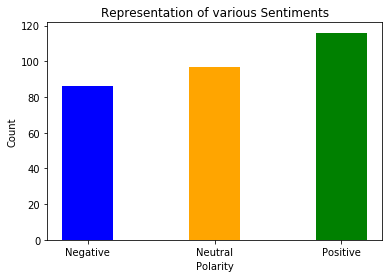

In [10]:
new_files_list = ['tweets_zeroplastic']
assign_scores(new_files_list)

In [11]:
# We load the url of the first file.
url = new_files_list[0] + "_final_" + ".json"

# JSON file
f = open (url, "r")

# Reading from file
data = json.loads(f.read())

for i in range(2):
	print(str(data[i])+"\n")

{'created_at': 'Mon Mar 09 14:21:05 +0000 2020', 'text': '💬“There is no such thing as ‘away’. When we throw anything away it must go somewhere.” – Annie Leonard… https://t.co/6Vn5xfPbN1', 'after_clean_text': 'speech balloon no thing away throw anything away must go somewhere annie', 'hypernyms': 'away shift negative location propulsion speech_act situation necessity annie lighter-than-air_craft anything', 'score': -0.027777777777777776}

{'created_at': 'Mon Mar 09 13:42:32 +0000 2020', 'text': 'Ditch the plastic. Custom tote bags with designs to inspire #kindness at https://t.co/J1siEx1zOd. 100% #organic cot… https://t.co/zD62LlMJUm', 'after_clean_text': 'ditch plastic custom tote bags designs inspire', 'hypernyms': 'solid bag stimulate container excavation practice creating_by_mental_acts', 'score': 0.017857142857142856}



# Word Embedding

In [12]:
#Parse the word embedding file
import numpy as np
import os
import pandas as pd


def generate_embeddings(file_name):
    
    #dict to store word embeddings from glove file
    embeddings_index = {}
    f = open(os.path.join('glove.6B', 'glove.6B.100d.txt'), encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    print('Found %s word vectors in glove dict' % len(embeddings_index))
    #generate a set of unique tokens in entire corpus
    reviews = pd.read_csv(file_name)
    unique_tokens = set()
    for review in reviews['text']:
        unique_tokens.update(clean_text(review))
        
    print("Found %s unique tokens in corpus" % len(unique_tokens))
    
    
    
    # create a dictionary of tokens and their embeddings
    tokens_embeddings_dict = {}
    
    for word in unique_tokens:
        word_vector = embeddings_index.get(word)
        if word_vector is not None:
            tokens_embeddings_dict[word] = word_vector
            
    print("Number of embeddings from corpus generated: %s" % len(tokens_embeddings_dict))
    
    #Generate dataframe from dictionary to export
    # Create dataframe from dic and make keys, index in dataframe
    embeddings_df = pd.DataFrame.from_dict(tokens_embeddings_dict, orient='index')
    embeddings_df.to_csv("project_embeddings.csv")
    
    return None
    

In [13]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score, classification_report, f1_score
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn, sentiwordnet as swn
# Instantiate the WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [14]:
#generate embeddings for our corpus, makes a file project_embeddings.csv and stores it in directory
generate_embeddings("tweets with hypernyms.csv")

Found 400001 word vectors in glove dict
Found 575 unique tokens in corpus
Number of embeddings from corpus generated: 568


In [15]:
embeddings_df = pd.read_csv("project_embeddings.csv", index_col=0)

In [16]:
#clustering

def cluster_embeddings(df, num_of_clusters):
    
    kmeans = KMeans(n_clusters = num_of_clusters, random_state=42).fit(df)
    group_num = kmeans.labels_
    geo_centroids = kmeans.cluster_centers_
    
    #assign nearest word to geometric centroid in embedding space as centroid
    # find the index of the closest points from x to each class centroid
    close = pairwise_distances_argmin_min(geo_centroids, df, metric='euclidean')
    index_closest_points = close[0]
    word_centroids = df.iloc[index_closest_points].index
    
    #create dict of group number and centroids
    centroid_dict = {}
    for i in range(len(index_closest_points)):
        centroid_dict[i] = word_centroids[i]
    
    #create a dictionary of word and corresponding centroid
    
    #replace each label(group number) assigned by kmeans cluster algo with centroid word
    cen = [centroid_dict.get(group) for group in group_num]

    #create a dictionary
    word_centroid_dict = {}

    for i in range(df.shape[0]):
        word_centroid_dict[df.index[i]] = cen[i]
    
    return word_centroid_dict

In [17]:
def replace_with_centroids(text, word_centroid_dict):
    
    new_text = [word_centroid_dict.get(word) if word in word_centroid_dict else word for word in text]
    
    return new_text   
    
    

def swn_classifier(text):
 
    sentiment = 0.0
    tokens_count = 0.0
    
    #Calculating score
    for word in text:
        
        lemma = lemmatizer.lemmatize(word)
        if not lemma:
            continue
 
        synsets = wn.synsets(lemma)
        if not synsets:
            continue
        
        # Take the first synset, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        print()
 
        #sentiment is the difference between positive and negative score
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
 
    # Default: neither positive, nor negative
    if not tokens_count:
        return 0
 
    return sentiment

In [18]:
#calling the cluster function to generate a word centroid dictionary
num = 55   #roughly 11 words per cluster
word_centroid_dict = cluster_embeddings(embeddings_df, num)
#n_clusters = 10

In [ ]:
tweets = pd.read_csv("tweets with hypernyms.csv")

#arrays to store list of tokens, replaced words, scores
clean_tokens = []
replaced_tokens = []
y_predicted = []


#calling the main calculate function
for text in tweets["text"]:    
    clean_t = clean_text(text)
    clean_tokens.append(clean_t)
    
    replaced_t = replace_with_centroids(clean_t, word_centroid_dict)
    replaced_tokens.append(replaced_t)
    
    senti_score = swn_classifier(replaced_t)
    y_predicted.append(senti_score)
    
#Classify reviews according to setiment score assigned
#1 : positive, 0 : neutral, -1 : negative 
y_classified = []
for i in y_predicted:
    if i > 0:
        y_classified.append(1)
    elif i<0:
        y_classified.append(-1)
    elif i==0:
        y_classified.append(0)
        

#appending cols in df
#tweets["hypernyms"]
tweets["tokens"] = clean_tokens
tweets["replaced_centroids"] = replaced_tokens
tweets["sentiment_score"] = y_predicted
tweets["predicted_sentiment"] = y_classified

#exporting df
tweets.to_csv("Score_generation_hypernyms_word_embedding.csv", header=True)
tweets.head()

In [20]:
tweets.head()

,created_at,text,after_clean_text,hypernyms,score,tokens,replaced_centroids,sentiment_score,predicted_sentiment
0,Mon Mar 09 14:21:05 +0000 2020,\ud83d\udcac\u201cThere is no such thing as \u...,speech balloon no thing away throw anything aw...,location shift propulsion lighter-than-air_cra...,-0.027778,"[no, thing, throw, anything, away, must, go, s...","[not, nothing, come, nothing, come, not, come,...",-1.375,-1
1,Mon Mar 09 13:42:32 +0000 2020,Ditch the plastic. Custom tote bags with desig...,ditch plastic custom tote bags designs inspire,bag container stimulate excavation practice cr...,0.017857,"[ditch, plastic, custom, tote, bags, designs, ...","[aim, stainless, use, tote, tote, products, hope]",0.125,1
2,Mon Mar 09 13:15:54 +0000 2020,Itsu's solution to plastic.....\n\nIt feels be...,itsus solution plastic feels better nothing se...,good be awareness not advantage sensing itsus ...,0.100000,"[itsus, solution, plastic, feels, better, noth...","[itsus, aim, stainless, nothing, way, nothing,...",-0.625,-1
3,Mon Mar 09 13:14:12 +0000 2020,RT @EarthbasicsU: All our products are \ud83c\...,products leaf fluttering wind fallen leaf herb...,vascular_plant external_body_part use weather ...,0.000000,[products],[products],0.000,0
4,Mon Mar 09 11:16:25 +0000 2020,RT @EarthbasicsU: All our products are \ud83c\...,products leaf fluttering wind fallen leaf herb...,vascular_plant external_body_part use weather ...,0.000000,[products],[products],0.000,0


In [21]:
#Some examples:
for n in range(0,100,20):
    
    print("text:",tweets["text"][n])
    print("tokens:",tweets["tokens"][n])
    print("replaced centroids:",tweets["replaced_centroids"][n])
    print("sentiment_score:",tweets["sentiment_score"][n],'\n')

text: \ud83d\udcac\u201cThere is no such thing as \u2018away\u2019. When we throw anything away it must go somewhere.\u201d \u2013 Annie Leonard\u2026 https://t.co/6Vn5xfPbN1
tokens: ['no', 'thing', 'throw', 'anything', 'away', 'must', 'go', 'somewhere', 'annie']
replaced centroids: ['not', 'nothing', 'come', 'nothing', 'come', 'not', 'come', 'nothing', 'madness']
sentiment_score: -1.375 

text: RT @EarthbasicsU: All our products are \ud83c\udf43\ud83c\udf42 #biodegradable or\ud83c\udf3f#vegan or #crueltyfree \ud83d\udc30 or #sustainablysourced or\u267b\ufe0f #recyclable or #zeroplasti\u2026
tokens: ['products']
replaced centroids: ['products']
sentiment_score: 0.0 

text: RT @EarthbasicsU: All our products are \ud83c\udf43\ud83c\udf42 #biodegradable or\ud83c\udf3f#vegan or #crueltyfree \ud83d\udc30 or #sustainablysourced or\u267b\ufe0f #recyclable or #zeroplasti\u2026
tokens: ['products']
replaced centroids: ['products']
sentiment_score: 0.0 

text: RT @PulpTecLtd: Our mission is an o

In [20]:
word_centroid_dict

{'annie': 'lovely',
 'hands': 'instead',
 'mexico': 'states',
 'staff': 'given',
 'walk': 'instead',
 'making': 'time',
 'alternative': 'innovative',
 'pounds': 'pounds',
 'planned': 'next',
 'take': 'come',
 'roll': 'instead',
 'people': 'come',
 'recent': 'recent',
 'welsh': 'wales',
 'transport': 'instead',
 'effects': 'affecting',
 'eight': 'five',
 'team': 'time',
 'reusable': 'compostable',
 'average': 'drop',
 'wales': 'wales',
 'nothing': 'nothing',
 'reuse': 'compostable',
 'customer': 'offering',
 'interesting': 'fantastic',
 'bags': 'bag',
 'hear': 'tell',
 'step': 'follow',
 'ability': 'given',
 'flour': 'ingredients',
 'cruelty': 'madness',
 'growing': 'recent',
 'bar': 'instead',
 'line': 'instead',
 'lost': 'time',
 'lifestyle': 'lifestyles',
 'rs': 'heres',
 'still': 'not',
 'wash': 'shampoo',
 'setup': 'replaces',
 'swan': 'lovely',
 'must': 'not',
 'given': 'given',
 'bill': 'calls',
 'blend': 'products',
 'virus': 'virus',
 'big': 'time',
 'available': 'given',
 'wor